In [13]:
import multiprocessing

import tensorflow_datasets as tfds
import tensorflow as tf

from keras import Sequential
from keras.layers import Dense, Flatten, Conv2D, MaxPooling2D

In [14]:
# Parallel extract

train_data = tfds.load("cats_vs_dogs", split="train", with_info=True)

file_pattern = (
    "/Users/iulian/tensorflow_datasets/cats_vs_dogs/4.0.1/cats_vs_dogs-train.tfrecord*"
)
files = tf.data.Dataset.list_files(file_pattern)

train_dataset = files.interleave(
    tf.data.TFRecordDataset,
    # How many records to process in parallel pe call
    cycle_length=4,
    # How many parallel calls to make (number of threads)
    num_parallel_calls=tf.data.experimental.AUTOTUNE,
)

In [15]:
# Parallel transform


def read_tfrecord(serialized_example):
    feature_description = {
        "image": tf.io.FixedLenFeature((), tf.string, ""),
        "label": tf.io.FixedLenFeature((), tf.int64, -1),
    }
    example = tf.io.parse_single_example(serialized_example, feature_description)
    image = tf.io.decode_jpeg(example["image"], channels=3)
    image = tf.cast(image, tf.float32)
    image = image / 255
    image = tf.image.resize(image, (300, 300))
    return image, example["label"]


cores = multiprocessing.cpu_count()
print(cores)
train_dataset = train_dataset.map(read_tfrecord, num_parallel_calls=cores)
train_dataset = train_dataset.cache()

8


In [16]:
# Data preprocessing
train_dataset = train_dataset.shuffle(1024).batch(32)
train_dataset = train_dataset.prefetch(tf.data.experimental.AUTOTUNE)

In [18]:
# Create cats vs dogs model
model = Sequential(
    [
        Conv2D(16, (3, 3), activation="relu", input_shape=(300, 300, 3)),
        MaxPooling2D(2, 2),
        Conv2D(32, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Conv2D(64, (3, 3), activation="relu"),
        MaxPooling2D(2, 2),
        Flatten(),
        Dense(512, activation="relu"),
        Dense(1, activation="sigmoid"),
    ]
)

model.compile(loss="binary_crossentropy", optimizer="adam", metrics=["accuracy"])

history = model.fit(train_dataset, epochs=10, verbose=1, steps_per_epoch=10)

Epoch 1/10
10/10 [==============================] - 9s 732ms/step - loss: 0.7114 - accuracy: 0.5094
Epoch 2/10
10/10 [==============================] - 7s 733ms/step - loss: 0.6997 - accuracy: 0.4719
Epoch 3/10
10/10 [==============================] - 7s 729ms/step - loss: 0.6921 - accuracy: 0.5531
Epoch 4/10
10/10 [==============================] - 7s 731ms/step - loss: 0.6951 - accuracy: 0.5000
Epoch 5/10
10/10 [==============================] - 7s 750ms/step - loss: 0.6877 - accuracy: 0.5500
Epoch 6/10
10/10 [==============================] - 8s 758ms/step - loss: 0.6931 - accuracy: 0.5000
Epoch 7/10
10/10 [==============================] - 7s 744ms/step - loss: 0.6946 - accuracy: 0.4719
Epoch 8/10
10/10 [==============================] - 8s 757ms/step - loss: 0.6938 - accuracy: 0.4656
Epoch 9/10
10/10 [==============================] - 8s 749ms/step - loss: 0.6924 - accuracy: 0.5375
Epoch 10/10
10/10 [==============================] - 7s 749ms/step - loss: 0.6943 - accuracy: 0.5219

2024-08-26 14:13:56.061346: W tensorflow/core/kernels/data/cache_dataset_ops.cc:856] The calling iterator did not fully read the dataset being cached. In order to avoid unexpected truncation of the dataset, the partially cached contents of the dataset  will be discarded. This can happen if you have an input pipeline similar to `dataset.cache().take(k).repeat()`. You should use `dataset.take(k).cache().repeat()` instead.


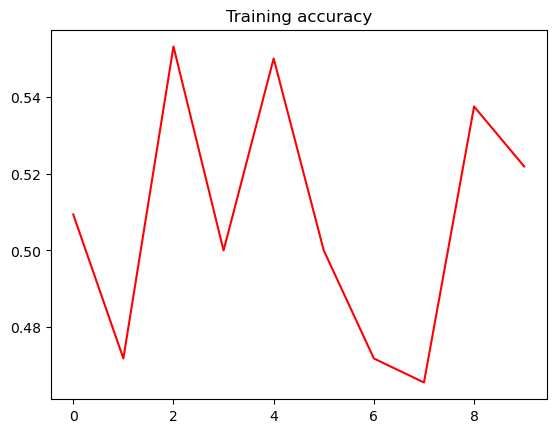

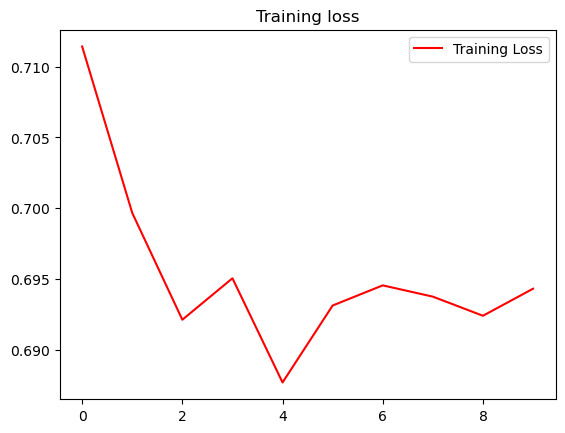

In [19]:
import matplotlib.pyplot as plt

acc = history.history["accuracy"]
loss = history.history["loss"]

epochs = range(len(acc))

plt.plot(epochs, acc, "r", label="Training accuracy")
plt.title("Training accuracy")

plt.figure()

plt.plot(epochs, loss, "r", label="Training Loss")
plt.title("Training loss")
plt.legend()

plt.show()